In [1]:
import numpy as np
import open3d as o3d
import utils
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


In [12]:
# code adapted from: https://github.com/ClayFlannigan/icp
def calculate_transform(X, Y):

    # get number of dimensions
    dims = X.shape[1]

    #calculate Xbar, Xprime
    Xbar = np.mean(X, axis=0)
    Xp = X - Xbar
    #calculate Ybar and Yprime
    Ybar = np.mean(Y, axis=0)
    Yp = Y - Ybar

    H = np.dot(Xp.T, Yp)
    U, S, Vt = np.linalg.svd(H)
    #calculate the rotation matrix
    R = np.dot(Vt.T, U.T)

    #account for if the image is flipped
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    #calculate the translation vector
    t = Ybar.T - np.dot(R,Xbar.T)
    T = np.identity(dims+1)

    #append everything to a single matrix for easier math
    T[:dims, :dims] = R
    T[:dims, dims] = t
    return T, R, t


def NN1(src, dst):
    neigh = NearestNeighbors(n_neighbors=1).fit(dst)
    dist, idx = neigh.kneighbors(src, return_distance=True)
    return dist.ravel(), idx.ravel()

def icp(X, Y, iters=20, convergence=0.001):

    dims = X.shape[1]

    # copy point clouds and append extra dimension for matrix math
    src = np.ones((dims+1,X.shape[0]))
    src[:dims,:] = np.copy(X.T)

    dst = np.ones((dims+1,Y.shape[0]))
    dst[:dims,:] = np.copy(Y.T)

    prev_error = 0

    for i in range(iters):
        # Use 1 nearest neighbor for point assignment
        distances, indices = NN1(src[:dims,:].T, dst[:dims,:].T)

        # compute the transform for the point assignment
        Tau,_,_ = calculate_transform(src[:dims,:].T, dst[:dims,indices].T)

        # apply transform 
        src = np.dot(Tau, src)

        # check for convergence
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < convergence:
            break
        prev_error = mean_error

    # calculate final transformation
    Tau,_,_ = calculate_transform(X, src[:dims,:].T)

    return Tau, distances, i

In [13]:
def rotation_matrix(axis, theta):
    axis = axis/np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis*np.sin(theta/2.)
    return np.array([[a*a+b*b-c*c-d*d, 2*(b*c-a*d), 2*(b*d+a*c)],
                  [2*(b*c+a*d), a*a+c*c-b*b-d*d, 2*(c*d-a*b)],
                  [2*(b*d-a*c), 2*(c*d+a*b), a*a+d*d-b*b-c*c]])

In [14]:
source, target = utils.prepare_source_and_target_nonrigid_3d('fish-y.txt', 'fish-y.txt', 0.001)
source_np = np.asarray(source.points)
source_np = source_np+np.random.rand()*.1
source_np = np.dot(rotation_matrix(np.random.rand(3),np.random.rand()*1),source_np.T).T
target_np = np.asarray(target.points)

PointCloud with 91 points.
PointCloud with 91 points.


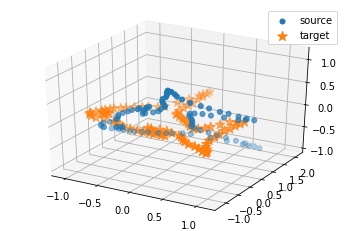

In [15]:
#not registered images overlayed
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(source_np[:,0], source_np[:,1], source_np[:,2], marker = '.', label = 'source', s = 100.0 )
ax.scatter(target_np[:,0], target_np[:,1], target_np[:,2], marker = '*', label = 'target', s = 100.0 )
plt.legend()

In [16]:
Transform, R1, t1 = icp(source_np, target_np,convergence=0.0001)

In [17]:
C = np.ones((91, 4))
C[:,0:3] = np.copy(source_np)
registered = np.dot(Transform,(C).T).T

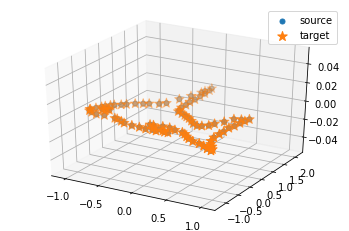

In [18]:
#Registered images 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(registered[:,0], registered[:,1], registered[:,3]-1, marker = '.', label = 'source', s = 100.0 )
ax.scatter(target_np[:,0], target_np[:,1], target_np[:,2], marker = '*', label = 'target', s = 100.0 )
plt.legend()